In [1]:
import os
import shutil


import gym
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd


from itertools import count
from collections import namedtuple
from collections import defaultdict
from torch.autograd import Variable
from torch.optim import lr_scheduler
from tqdm import tnrange
from random import choice

from complex_gridword import GridworldEnv
from nets import *
from draw_methods import *
from hyper_parametrs import *
from env_methods import *
from tensorboardX import SummaryWriter
from utils import command



In [2]:
#shutil.rmtree(logs_directory)
writer = SummaryWriter(logs_directory)
board = command.Command('tensorboard --logdir=run1:{} --port {}'.format(logs_directory, board_port))
board.run()

In [3]:
shutil.copy("hyper_parametrs.py", logs_directory)

'./plots/pillar_9x9_siamese/hyper_parametrs.py'

In [4]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['choice']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
grid_size = (9, 9)
env_name = "simple"
grid_map = np.load("gridworlds_data/{}_{}x{}/grid_map.npy".format(env_name, grid_size[0], grid_size[1]))
env = GridworldEnv(grid_size, grid_map)

In [6]:
state_dim = int(env.nS * 2)
action_dim = int(env.nA)

In [7]:
def entropy_term(probs):
    return -torch.sum(probs * torch.log(probs))

In [8]:
def update_params(agent, optimizer, losses_history):
    R = 0
    saved_actions = agent.saved_actions
    value_loss = 0
    rewards = []
    for r in agent.rewards[::-1]:
        R = r + gamma_rl * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    log_loss = Variable(torch.FloatTensor([0]))
    val_loss = Variable(torch.FloatTensor([0]))
    entropy_loss = Variable(torch.FloatTensor([0]))
    for (action, probs, value), r in zip(saved_actions, rewards):
        m = torch.distributions.Categorical(probs)
        reward = r - value.data[0, 0]
        log_loss  += -(m.log_prob(action[0]) * reward)
        val_loss += lambda_baseline * F.mse_loss(value, Variable(torch.Tensor([r])))
        entropy_loss += -entropy_weights["agent"] * entropy_term(probs)
    
    losses_history["entropy"].append(entropy_loss.data.numpy()[0])
    losses_history["value loss"].append(val_loss.data.numpy()[0])
    losses_history["log loss"].append(log_loss.data.numpy()[0])
    loss = log_loss + val_loss + entropy_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    del agent.rewards[:]
    del agent.saved_actions[:]


In [9]:
env_type = "simple"

In [10]:
Expert_left_corner = NovelExpert("left_top_corner", np.load("gridworlds_data/{}_{}x{}/agents_left_corner/action_probs.npy".format(env_name, grid_size[0], grid_size[1])), 
                            np.load("gridworlds_data/{}_{}x{}/agents_left_corner/value_function.npy".format(env_name, grid_size[0], grid_size[1])),
                            np.load("gridworlds_data/{}_{}x{}/agents_left_corner/goal_map.npy".format(env_name, grid_size[0], grid_size[1])))
Expert_right_corner = NovelExpert("right_bottom_corner", np.load("gridworlds_data/{}_{}x{}/agents_right_corner/action_probs.npy".format(env_name, grid_size[0], grid_size[1])), 
                            np.load("gridworlds_data/{}_{}x{}/agents_right_corner/value_function.npy".format(env_name, grid_size[0], grid_size[1])),
                            np.load("gridworlds_data/{}_{}x{}/agents_right_corner/goal_map.npy".format(env_name, grid_size[0], grid_size[1])))
Expert_global_optimal = NovelExpert("global_optimal", np.load("gridworlds_data/{}_{}x{}/agents_global_optimal/action_probs.npy".format(env_name, grid_size[0], grid_size[1])), 
                            np.load("gridworlds_data/{}_{}x{}/agents_global_optimal/value_function.npy".format(env_name, grid_size[0], grid_size[1])),
                            np.load("gridworlds_data/{}_{}x{}/agents_global_optimal/goal_map.npy".format(env_name, grid_size[0], grid_size[1])))
possible_s_stars = [0, env.nS - 1]

In [11]:
siamese_net = torch.load("pretrained_nets/siamese_{}_{}x{}.pt".format(env_name, grid_size[0], grid_size[1]))

In [12]:
max_true_d = 0 

for s1 in range(env.nS):
    for s2 in range(env.nS):
        if env.grid_map[s1] and env.grid_map[s2]:
            max_true_d = max(max_true_d, abs(s1 % int(np.sqrt(env.nS)) - s2 % int(np.sqrt(env.nS))) + abs(s1 // int(np.sqrt(env.nS)) - s2 // int(np.sqrt(env.nS))))

In [13]:
def goal_unsim(env, g1, g2, metric_type='siamnet'):
    #print(g1)
    #print(g2)
    if metric_type =='siam':
        return (1.0 - siamese_net(np.array([(g1, g2)]))).data.numpy()[0][0]
    else:
        global env_type
        if env.grid_map[g1] == 0 or env.grid_map[g2] == 0:
                return 1000
        if env_type == "simple" or "pillar":
            return (abs(g1 % int(np.sqrt(env.nS)) - g2 % int(np.sqrt(env.nS))) + abs(g1 // int(np.sqrt(env.nS)) - g2 // int(np.sqrt(env.nS)))) /  max_true_d
        else:
            if env.grid_map[g1] == 0 or env.grid_map[g2] == 0:
                return 1000
            r1 = np.abs(Expert_left_corner.v_function[g1] - Expert_left_corner.v_function[g2])
            r2 = np.abs(Expert_right_corner.v_function[g1] - Expert_right_corner.v_function[g2])
            return min(r1, r2) /  max_true_d
    
    
def goal_based_training(env, tmax, agent, goal, optimizer, losses_history, agent_type): 
    time = 0
    done = False
    while True:
        if is_terminal(env, env.s): #done
            break
        time += 1
        a = agent.select_action(env.s, goal)
        state, _, done, _= env.step(a[0, 0])
        if is_terminal(env, env.s):
            if is_terminal(env, env.s): #done
                break
        if time >= tmax:
            break
        agent.rewards.append(0)
    
    if "goal-based" in agent_type:
        final_reward = (-time - lambda_goals  * goal_unsim(env, goal, env.s, agent.metric_type)) / scale_reward 
    else:
        final_reward = (-time) / scale_reward 
    agent.rewards.append(final_reward)
    if(len(agent.saved_actions)):
        update_params(agent, optimizer, losses_history)
    
    del agent.rewards[:]
    del agent.saved_actions[:]

    return final_reward
    

In [14]:
def choose_goal(env, experts, s0, iteration, agent_type="goal-based"):
    #print(s0)
    if "goal-based" in agent_type:
        best_goal = None
        best_goal_v = -np.inf
        possible_goals = [0, env.nS - 1]
        for expert in experts:
            possible_goals.append(expert.get_goal(s0))
            if expert.v_function[s0] > best_goal_v:
                best_goal = expert.get_goal(s0)
                best_goal_v = expert.v_function[s0]
        
        if goal_sampling_strategy == "eps_greedy":
            if np.random.random() < goal_eps:
                goal_eps *= goal_eps_decay
                return np.random.choice(possible_goals) 
            else:
                return int(best_goal)
        
        if goal_sampling_strategy == "random":
            return int(possible_goals[iteration % 2])
    return None
    
def train_agent(env, tmax, each_goal_times, agent, experts, optimizer, losses_history, i, agent_type):
    rewards = []
    episode_time = []
    finish_states = []
    set_random_s0(env)
    s0 = env.reset()
    goal = choose_goal(env, experts, s0, i, agent_type)
    res = goal_based_training(env, tmax, agent, goal, optimizer, losses_history, agent_type)   
    rewards.append(res)
    
    return agent, np.array(rewards)

In [15]:
def set_env_s0(env, s0):
    env.isd = np.zeros(env.shape[0] * env.shape[1])
    env.isd[s0] = 1 

def play_n_episodes(n, env, model, s0_list, s_star, tmax=40):
    state_dist_list = []
    for i in range(n):
        set_env_s0(env, s0_list[i])
        env.reset()
        state_dist_episode = np.zeros(env.shape)
        for j in range(tmax):
            s = env.s
            state_dist_episode[s // env.shape[0]][s % env.shape[1]] += 1
            if(is_terminal(env, env.s)):
                break
            probs, state_value = model(s, s_star)
            action = probs.multinomial().data
            env.step(action[0][0])
        state_dist_list.append(state_dist_episode)
    
    state_dist = np.zeros(env.shape)
    
    for dist in state_dist_list:
        state_dist += dist
    
    return state_dist / n, state_dist_list  

In [16]:
import shutil
plots_dir = "plots_compare"
try:
    shutil.rmtree(plots_dir)
except:
    pass
try:
    os.mkdir(plots_dir)
except:
    pass

In [17]:
losses_history_goal_based = {
    "entropy":[],
    "value loss":[],
    "log loss":[]
}

losses_history_simple = {
    "entropy":[],
    "value loss":[],
    "log loss":[]
}

In [18]:
agent_goal_based_true = Agent(state_dim, action_dim, "goal-based", "true")
agent_goal_based_siam = Agent(state_dim, action_dim, "goal-based", "siam")

In [ ]:
g1 = 0
g2 = 40
goal_unsim(env, g1, g2, metric_type='siamnet')

In [20]:
stats = defaultdict(list)

reset_times = 10

for time in range(reset_times):
    agent_goal_based_true = Agent(state_dim, action_dim, "goal-based", "true")
    agent_goal_based_siam = Agent(state_dim, action_dim, "goal-based", "siam")
    agent_simple = Agent(state_dim, action_dim, "simple")

    optimizer_goal_based_agent_true = optim.Adam(agent_goal_based.parameters(),lr=lr_agent, weight_decay=weight_decay)
    optimizer_goal_based_agent_siam = optim.Adam(agent_goal_based.parameters(),lr=lr_agent, weight_decay=weight_decay)
    optimizer_simple_agent = optim.Adam(agent_simple.parameters(),lr=lr_agent, weight_decay=weight_decay)

    
    each_goal_times = 1
    start = 0
    models = [agent_goal_based_true, agent_goal_based_siam, agent_simple, Expert_global_optimal]
    experts = [Expert_global_optimal]
    reward_history = defaultdict(list)

    estimate_every = 500
    estimation_episodes_num = 500

    for i in tnrange(train_steps):
        agent_goal_based_true, rewards = train_agent(env, tmax, each_goal_times, agent_goal_based_true, experts, optimizer_goal_based_agent, losses_history_goal_based_true, i, agent_type="goal-based")
        agent_goal_based_siam, rewards = train_agent(env, tmax, each_goal_times, agent_goal_based_siam, experts, optimizer_goal_based_siam, losses_history_goal_based_siam, i, agent_type="goal-based")
        agent_simple, rewards = train_agent(env, tmax, each_goal_times, agent_simple, experts, optimizer_simple_agent, losses_history_simple, i, agent_type="simple")

        #fig, ax = subplots(nrows=1, ncols=1, figsize=(12, 6))
        models = [agent_goal_based_true, agent_goal_based_siam, agent_simple, Expert_global_optimal]
        models_anotations = ["goal-based true-metric agent", "goal-based siam-metric agent", "simple agent", "Expert global optimal"]


        if (i + 1) % estimate_every == 0:

            s0_list = np.random.choice(np.array(np.where(env.grid_map)).flatten(), size=estimation_episodes_num)

            current_rewards = get_agents_reward(env, models, models_anotations, tmax, possible_s_stars, s0_list, estimation_episodes_num)

            for model_name, model_reward in zip(current_rewards.keys(), current_rewards.values()):
                reward_history[model_name].append(np.mean(model_reward))
    
    stats["goal based"].append(reward_history["goal-based agent"])
    print("%d goal based last: %.4f" % (time, np.array(stats["goal based"])[-1, -1]))
    print("%d goal based mean: %.4f" % (time, np.mean(np.array(stats["goal based"])[:, -1], axis=0)))
    
    stats["simple agent"].append(reward_history["simple agent"])
    print("%d simple agent last: %.4f" % (time, np.array(stats["simple agent"])[-1, -1]))
    print("%d simple agent mean: %.4f" % (time, np.mean(np.array(stats["simple agent"])[:, -1], axis=0)))
    
    print("#" * 100)

/Users/andrejklimkin/Documents/Coursework/2017-2018/main/source/experts-learning/nets.py:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(action_scores), state_values


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/Users/andrejklimkin/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/andrejklimkin/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




0 goal based last: -5.3240
0 goal based mean: -5.3240
0 simple agent last: -8.1220
0 simple agent mean: -8.1220
####################################################################################################

1 goal based last: -5.3940
1 goal based mean: -5.3590
1 simple agent last: -7.7860
1 simple agent mean: -7.9540
####################################################################################################

2 goal based last: -7.8720
2 goal based mean: -6.1967
2 simple agent last: -7.9920
2 simple agent mean: -7.9667
####################################################################################################

3 goal based last: -5.3000
3 goal based mean: -5.9725
3 simple agent last: -8.1040
3 simple agent mean: -8.0010
####################################################################################################

4 goal based last: -5.2840
4 goal based mean: -5.8348
4 simple agent last: -7.9380
4 simple agent mean: -7.9884
###############################

In [21]:
np.mean(np.array(stats["goal based"]), axis=0)

array([-33.8546, -30.5522, -19.695 , -15.7532, -13.9772, -12.9772,
       -12.4752, -11.902 , -11.5734, -11.2158, -10.9202, -10.2894,
        -9.6354,  -9.4364,  -8.9554,  -9.056 ,  -8.5738,  -8.4132,
        -7.9822,  -7.8764,  -7.2082,  -7.1242,  -6.6822,  -6.3096,
        -6.347 ,  -6.105 ,  -5.9102,  -5.6952,  -5.6026,  -5.5702])

In [24]:
#pd.DataFrame(stats).to_csv("stats/simple_9x9.csv")

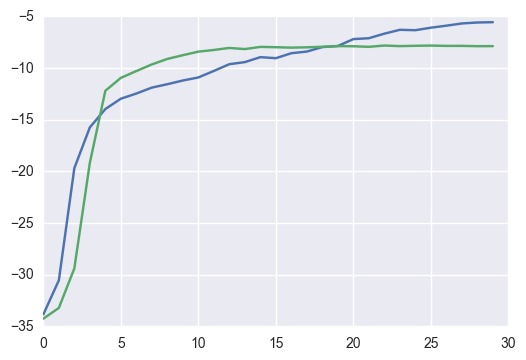

In [23]:
plt.plot(np.mean(np.array(stats["goal based"]), axis=0))
plt.plot(np.mean(np.array(stats["simple agent"]), axis=0))

In [33]:
np.mean(np.array(stats["simple agent"]), axis=0)

array([-13.3784,  -5.9348,  -4.8472,  -4.1542,  -3.9472,  -3.845 ,
        -3.7452,  -3.7122,  -3.741 ,  -3.628 ,  -3.6458,  -3.6514,
        -3.5716,  -3.4908,  -3.4798,  -3.3726,  -3.3496,  -3.1946,
        -3.179 ,  -3.188 ,  -3.11  ,  -3.1232,  -3.0876,  -3.0212,
        -3.0388])

In [25]:
np.mean(np.array(stats["goal based"]), axis=0)

array([[-10.666,  -5.924,  -4.728,  -4.102,  -3.952,  -3.962,  -3.818,
         -3.646,  -3.89 ,  -3.7  ,  -3.696,  -3.704,  -3.784,  -3.626,
         -3.754,  -3.666,  -3.622,  -3.55 ,  -3.63 ,  -3.54 ,  -3.268,
         -3.572,  -3.4  ,  -3.456,  -3.504],
       [-15.234,  -5.644,  -4.578,  -4.062,  -3.764,  -3.852,  -3.672,
         -3.84 ,  -3.628,  -3.796,  -3.602,  -3.502,  -3.526,  -3.598,
         -3.506,  -3.432,  -3.676,  -3.258,  -3.506,  -3.472,  -3.492,
         -3.486,  -3.33 ,  -3.124,  -3.054],
       [-19.294,  -5.694,  -4.752,  -4.128,  -3.758,  -3.762,  -3.66 ,
         -3.834,  -3.558,  -3.802,  -3.584,  -3.542,  -3.174,  -3.206,
         -3.324,  -3.052,  -2.908,  -2.592,  -2.706,  -2.484,  -2.646,
         -2.57 ,  -2.534,  -2.628,  -2.68 ],
       [-20.016,  -7.03 ,  -5.164,  -4.056,  -3.584,  -3.014,  -2.938,
         -2.732,  -2.626,  -2.44 ,  -2.458,  -2.36 ,  -2.43 ,  -2.428,
         -2.342,  -2.454,  -2.464,  -2.384,  -2.46 ,  -2.46 ,  -2.412,
         -2.4

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
for s in range(1, env.nS - 1):
    if env.grid_map[s] == 0:
        continue

    agent = Expert_global_optimal


    ax.set_xticks(np.arange(0, int(np.sqrt(env.nS)) + 1))
    ax.set_yticks(np.arange(0, int(np.sqrt(env.nS)) + 1))
    probs = agent.action_probs[s]
    draw_direction_probs(plt, env, s, probs)
    ax.invert_yaxis()

In [ ]:
for i in range(49):
    print(i, Expert_global_optimal.action_probs[i])

In [22]:
g1 = 0
g2 = 1
siamese_net(np.array([(g1, g2)]))

Variable containing:
1.00000e-04 *
  1.0471
[torch.FloatTensor of size 1x1]

In [ ]:
torch.load("pretrained_nets/siamese_5x5.pt")(np.array([(g1, g2)]))

# board.wait(board_timeout)

In [22]:
np.mean(get_policy_reward_estimation(env, agent_goal_based, 'agent', 1000, 40, s_star=[0, 24]))

/Users/andrejklimkin/Documents/Coursework/2017-2018/main/source/experts-learning/nets.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(action_scores), state_values


-11.03

In [23]:
s = 1
agent_goal_based(s, 0)

/Users/andrejklimkin/Documents/Coursework/2017-2018/main/source/experts-learning/nets.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(action_scores), state_values


(Variable containing:
  0.2266  0.1318  0.0942  0.5474
 [torch.FloatTensor of size 1x4], Variable containing:
 -2.5737
 [torch.FloatTensor of size 1x1])

In [24]:
agent_simple(s)

/Users/andrejklimkin/Documents/Coursework/2017-2018/main/source/experts-learning/nets.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(action_scores), state_values


(Variable containing:
  0.0607  0.4443  0.4541  0.0409
 [torch.FloatTensor of size 1x4], Variable containing:
 -0.9203
 [torch.FloatTensor of size 1x1])

In [ ]:
np.mean(get_policy_reward_estimation(env, agent_simple, 'agent', 1000, 40, s_star=[None]))

In [ ]:
agent_simple(s)

In [ ]:
probs = Variable(torch.FloatTensor([0.5, 0.5]))
m = torch.distributions.Categorical(probs)
m.log_prob(Variable(torch.LongTensor(1)))